In [16]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Анализ и очистка датасета

In [17]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
100%|██████████████████████████████████████| 1.08G/1.08G [01:44<00:00, 10.5MB/s]
100%|██████████████████████████████████████| 1.08G/1.08G [01:44<00:00, 11.1MB/s]


In [18]:
with zipfile.ZipFile('the-simpsons-characters-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
#Вместо того, чтобы доверять файлу number_pic_char.csv — изучим фактическое содержимое папок
dataset_folder = "simpsons_dataset"  # Путь к основной папке с данными
kaggle_test_folder = "kaggle_simpson_testset/kaggle_simpson_testset"  # Путь к папке с тестовым набором данных

# Словарь для хранения количества изображений в каждой папке персонажей
dataset_counts = {}
kaggle_test_counts = {}

In [20]:
# Подсчет количества изображений в каждой папке персонажей в 'simpsons_dataset'
for character in os.listdir(dataset_folder):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.isdir(character_folder_path):
        image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        dataset_counts[character] = image_count

In [21]:
# Подсчет количества изображений в 'kaggle_simpsons_testset' с учетом шаблона именования файлов
for file_name in os.listdir(kaggle_test_folder):
    if os.path.isfile(os.path.join(kaggle_test_folder, file_name)):
        # Извлечение имени персонажа из имени файла, удаляя часть после последнего подчеркивания и номера
        character = '_'.join(file_name.split('_')[:-1])
        if character in kaggle_test_counts:
            kaggle_test_counts[character] += 1
        else:
            kaggle_test_counts[character] = 1

In [22]:
# Создание DataFrame для удобного отображения результатов
dataset_df = pd.DataFrame(list(dataset_counts.items()), columns=['Класс', 's_d'])
kaggle_test_df = pd.DataFrame(list(kaggle_test_counts.items()), columns=['Класс', 'k_s_t'])

In [23]:
# Объединяем информацию из двух папок, чтобы сравнить
combined_df = pd.merge(dataset_df, kaggle_test_df, on='Класс', how='outer').fillna(0)
combined_df.rename(columns={'k_s_t': 'k_s_t'}, inplace=True)
combined_df['s_d'] = combined_df['s_d'].astype(int)
combined_df['k_s_t'] = combined_df['k_s_t'].astype(int)

# Выводим информацию о количестве изображений в каждой папке
print(combined_df[['Класс', 's_d', 'k_s_t']].sort_values(by=['s_d', 'k_s_t'], ascending=False))

                       Класс   s_d  k_s_t
41             homer_simpson  2246     50
23              ned_flanders  1454     49
17               moe_szyslak  1452     50
36              lisa_simpson  1354     50
35              bart_simpson  1342     50
28             marge_simpson  1291     50
25          krusty_the_clown  1206     50
34         principal_skinner  1194     50
2   charles_montgomery_burns  1193     48
6        milhouse_van_houten  1079     49
5               chief_wiggum   986     50
24    abraham_grampa_simpson   913     48
11              sideshow_bob   877     47
27    apu_nahasapeemapetilon   623     50
32             kent_brockman   498     50
29            comic_book_guy   469     49
19            edna_krabappel   457     50
30              nelson_muntz   358     50
10             lenny_leonard   310     50
31              mayor_quimby   246     50
26           waylon_smithers   181      0
0             maggie_simpson   128      0
21      groundskeeper_willie   121

Видим, что среди персонажей затесалась лишняя папка simpsons_dataset. Важно сопоставить ее содержимое с основным массивом — вдруг там новые данные.

Также можем сравнить содержимое основной и тестовой папок —  видимо название соотвествует содержимому и в тесте лежат тестовые данные. Поскольку мы будем выделять тестовую часть выборки позже — считаю данные из теста можно объединить с основными.

In [24]:
# Проверка вложенной папки 'simpsons_dataset/simpsons_dataset'
nested_dataset_folder = os.path.join(dataset_folder, 'simpsons_dataset')
nested_dataset_counts = {}

if os.path.exists(nested_dataset_folder) and os.path.isdir(nested_dataset_folder):
    for character in os.listdir(nested_dataset_folder):
        character_folder_path = os.path.join(nested_dataset_folder, character)
        if os.path.isdir(character_folder_path):
            image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
            nested_dataset_counts[character] = image_count

In [25]:
# Сравнение изображений из основной и вложенной папок
from hashlib import md5

def get_file_checksum(file_path):
    with open(file_path, 'rb') as f:
        return md5(f.read()).hexdigest()

matching_files = []
different_files = []

In [26]:
for character in dataset_counts.keys():
    original_folder = os.path.join(dataset_folder, character)
    nested_folder = os.path.join(nested_dataset_folder, character)

    if os.path.exists(nested_folder):
        original_files = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]
        nested_files = [f for f in os.listdir(nested_folder) if os.path.isfile(os.path.join(nested_folder, f))]

        for file_name in original_files:
            original_file_path = os.path.join(original_folder, file_name)
            nested_file_path = os.path.join(nested_folder, file_name)

            if os.path.exists(nested_file_path):
                original_checksum = get_file_checksum(original_file_path)
                nested_checksum = get_file_checksum(nested_file_path)

                if original_checksum == nested_checksum:
                    matching_files.append((original_file_path, nested_file_path))
                else:
                    different_files.append((original_file_path, nested_file_path))

print(f"Совпадающие файлы: {len(matching_files)}")
print(f"Различные файлы: {len(different_files)}")


Совпадающие файлы: 20933
Различные файлы: 0


По результатам проверки очевидно, что это дубликат. Значит его можно спокойно удалить.

In [27]:
# Перемещение изображений из 'kaggle_simpsons_testset' в соответствующие папки в 'simpsons_dataset'
missing_characters = []

for file_name in os.listdir(kaggle_test_folder):
    if os.path.isfile(os.path.join(kaggle_test_folder, file_name)):
        # Извлечение имени персонажа из имени файла, удаляя часть после последнего подчеркивания и номера
        character = '_'.join(file_name.split('_')[:-1])
        character_folder_path = os.path.join(dataset_folder, character)

        # Проверяем, существует ли папка для персонажа в основном датасете
        if os.path.exists(character_folder_path):
            # Перемещаем файл в соответствующую папку
            original_file_path = os.path.join(kaggle_test_folder, file_name)
            new_file_path = os.path.join(character_folder_path, file_name)
            os.rename(original_file_path, new_file_path)
        else:
            # Добавляем персонажа в список отсутствующих
            missing_characters.append(character)

# Вывод списка персонажей, для которых не нашлось соответствующих папок
print("Персонажи, для которых не нашлось соответствующих папок в основном датасете:")
print(set(missing_characters))

Персонажи, для которых не нашлось соответствующих папок в основном датасете:
set()


In [28]:
# Подсчет количества изображений в каждой папке после перемещения данных из 'kaggle_simpsons_testset'
dataset_counts_after_merge = {}
for character in os.listdir(dataset_folder):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.isdir(character_folder_path):
        image_count = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        dataset_counts_after_merge[character] = image_count

# Создание DataFrame для удобного отображения результатов после объединения
dataset_df_after_merge = pd.DataFrame(list(dataset_counts_after_merge.items()), columns=['Класс', 's_d'])

# Выводим информацию о количестве изображений в каждой папке после объединения
print("Количество изображений в каждой папке после объединения с тестовой выборкой:")
print(dataset_df_after_merge.sort_values(by=['s_d'], ascending=False))

Количество изображений в каждой папке после объединения с тестовой выборкой:
                       Класс   s_d
41             homer_simpson  2296
23              ned_flanders  1503
17               moe_szyslak  1502
36              lisa_simpson  1404
35              bart_simpson  1392
28             marge_simpson  1341
25          krusty_the_clown  1256
34         principal_skinner  1244
2   charles_montgomery_burns  1241
6        milhouse_van_houten  1128
5               chief_wiggum  1036
24    abraham_grampa_simpson   961
11              sideshow_bob   924
27    apu_nahasapeemapetilon   673
32             kent_brockman   548
29            comic_book_guy   518
19            edna_krabappel   507
30              nelson_muntz   408
10             lenny_leonard   360
31              mayor_quimby   296
26           waylon_smithers   181
0             maggie_simpson   128
21      groundskeeper_willie   121
14             barney_gumble   106
13             selma_bouvier   103
18           

In [29]:
# Удаление вложенной папки после проверки
import shutil
import os

# Define the path to the directory you want to delete
directory_path = '/Users/alexpti4ka/Documents/Cursor_projects/ML/simpsons_dataset/simpsons_dataset'

# Check if the directory exists before attempting to delete it
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print("Папка '/simpsons_dataset/simpsons_dataset' удалена.")
else:
    print(f"Папка '{directory_path}' не найдена.")

Папка '/simpsons_dataset/simpsons_dataset' удалена.


In [30]:
df = pd.DataFrame(list(dataset_counts_after_merge.items()), columns=['name', 'count'])

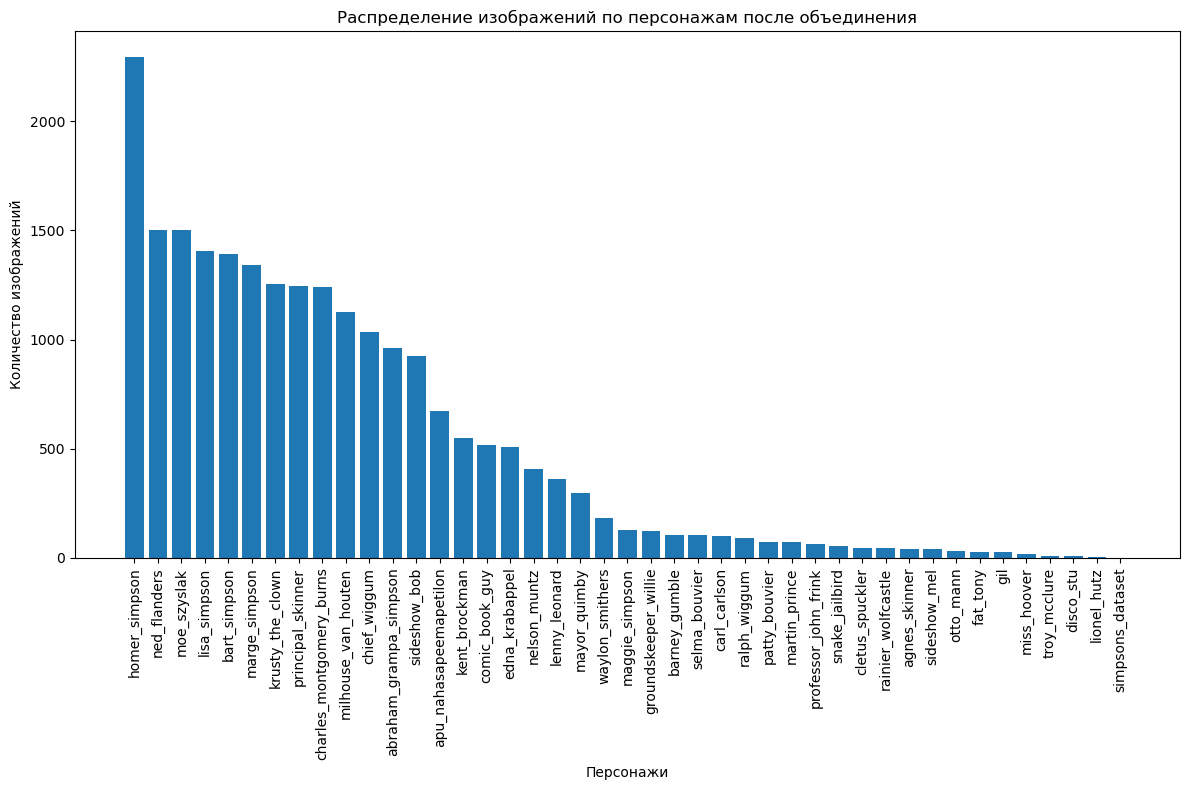

In [31]:
# Настройка графика
plt.figure(figsize=(12, 8))
df_sorted = df.sort_values(by=['count'], ascending=False)
plt.bar(df_sorted['name'], df_sorted['count'])
plt.xlabel('Персонажи')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по персонажам после объединения')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
#Видимо, что для некоторых персонажей информации очень мало. Посмотрим, насколько мало
min_values = df.nsmallest(20, 'count')
print(min_values)

                    name  count
1       simpsons_dataset      1
15           lionel_hutz      3
38          troy_mcclure      8
40             disco_stu      8
39           miss_hoover     17
12              fat_tony     27
16                   gil     27
37             otto_mann     32
22          sideshow_mel     40
42         agnes_skinner     42
7     rainier_wolfcastle     45
8        cletus_spuckler     47
20        snake_jailbird     55
33  professor_john_frink     65
9          martin_prince     71
3          patty_bouvier     72
4           ralph_wiggum     89
18          carl_carlson     98
13         selma_bouvier    103
14         barney_gumble    106


Google Cloud рекомендует для CNN классификатора минимум 50–100 изображений на класс.
50 - если изображения внутри класса похожи. Важно не потерять разнообразие классов, поэтому будем проводить аугментацию для всех персонажей.

In [33]:
# Среднее кол-во изображений в классе имеет смысл считать уже на подвыборке
mean_count = df['count'].mean()
print(mean_count)

509.86046511627904


In [34]:
# Из распределения мы знаем, что у нас значительный дисбаланс классов
# Воспользуемся правилом х delta чтобы определить слишком малые и большие классы

delta = 5 #во сколько раз отличие от среднего

# Разбиваем классы на группы
# Слишком много данных (более чем в delta раз превышает среднее)
too_many_data = df[df['count'] > delta * mean_count]['name']

# Оптимальное количество данных (близко к среднему, в пределах delta)
optimal_data = df[(df['count'] <= delta * mean_count) & (df['count'] >= mean_count / delta)]['name']

# Слишком мало данных (более чем в delta раз меньше среднего)
too_few_data = df[df['count'] < mean_count / delta]['name']


# Преобразуем имена в нужный формат (чтобы совпадало с тем, что в папках)
formatted_too_many_data = too_many_data.str.lower().str.replace(' ', '_')
formatted_optimal_data = optimal_data.str.lower().str.replace(' ', '_')
formatted_too_few_data = too_few_data.str.lower().str.replace(' ', '_')

# Результаты
print("Классы с слишком большим количеством данных:", formatted_too_many_data.tolist())
print("Классы с оптимальным количеством данных:", formatted_optimal_data.tolist())
print("Классы с слишком малым количеством данных:", formatted_too_few_data.tolist())

Классы с слишком большим количеством данных: []
Классы с оптимальным количеством данных: ['maggie_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'milhouse_van_houten', 'lenny_leonard', 'sideshow_bob', 'selma_bouvier', 'barney_gumble', 'moe_szyslak', 'edna_krabappel', 'groundskeeper_willie', 'ned_flanders', 'abraham_grampa_simpson', 'krusty_the_clown', 'waylon_smithers', 'apu_nahasapeemapetilon', 'marge_simpson', 'comic_book_guy', 'nelson_muntz', 'mayor_quimby', 'kent_brockman', 'principal_skinner', 'bart_simpson', 'lisa_simpson', 'homer_simpson']
Классы с слишком малым количеством данных: ['simpsons_dataset', 'patty_bouvier', 'ralph_wiggum', 'rainier_wolfcastle', 'cletus_spuckler', 'martin_prince', 'fat_tony', 'lionel_hutz', 'gil', 'carl_carlson', 'snake_jailbird', 'sideshow_mel', 'professor_john_frink', 'otto_mann', 'troy_mcclure', 'miss_hoover', 'disco_stu', 'agnes_skinner']


In [35]:
dataset_folder = 'simpsons_dataset'

In [56]:
# Разделение на images и labels
images = []
labels = []

# Перебираем папки и собираем изображения и метки
for character in pd.concat([formatted_optimal_data, formatted_too_few_data]):
    character_folder_path = os.path.join(dataset_folder, character)
    if os.path.exists(character_folder_path):
        for file_name in os.listdir(character_folder_path):
            file_path = os.path.join(character_folder_path, file_name)
            if os.path.isfile(file_path):
                images.append(file_path)
                labels.append(character)

# Проверяем результаты разделения на images и labels
print(f'Количество изображений: {len(images)}')
print(f'Количество меток: {len(labels)}')
print(f'Пример изображения: {images[0] if images else "Нет изображений"}')
print(f'Пример метки: {labels[0] if labels else "Нет меток"}')

Количество изображений: 21923
Количество меток: 21923
Пример изображения: simpsons_dataset/maggie_simpson/pic_0028.jpg
Пример метки: maggie_simpson


# 3. Аугментация данных
Генерируем доп изображения в малые классы, чтобы скорректировать дисбаланс классов.

Что подойдет:
- Небольшое изменение масштаба, сдивиги, поворот


Что не подойдет:
- Ротация на 90 градусов и более
- Сильная обрезка изображений, фрагментирование портретов
- Изменение цвета для мультка со узнаваемой цветовой схемой это может быть фатально
- Сильный шум или размытие не характерны для скриншотов из мультика — такие методы скорее подойдут для фото из реальной жизни

Аугментацию можно проводить как отдельно, так и на лету (онлайн), прямо во время обучения модели, с использованием тех же библиотек tensorflow или аналогов.

Оставлю пример кода как для отедльной, так и для онлайновой аугментации.

In [23]:
# Настройка параметров генерации изображений
augmented_images = []
augmented_labels = []

datagen = ImageDataGenerator(
    rescale=1./255, #чтобы привести значение пикселя к от 0 до 1 (так лучше для модели)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation_counts = {}  # Для отслеживания количества сгенерированных изображений для каждого класса
augmented_image_paths = []  # Для хранения путей к сгенерированным изображениям

augmented_dataset_folder = "augmented_dataset"  # Папка для сохранения сгенерированных изображений
os.makedirs(augmented_dataset_folder, exist_ok=True)

In [24]:
# Аугментация для классов с недостаточным количеством данных
for character in formatted_too_few_data:
    character_folder_path = os.path.join(dataset_folder, character)
    augmented_character_folder_path = os.path.join(augmented_dataset_folder, character)
    os.makedirs(augmented_character_folder_path, exist_ok=True)

    if os.path.exists(character_folder_path):
        current_count = len(os.listdir(character_folder_path))
        target_count = int(mean_count)  # Целевое количество изображений для каждого класса = среднее
        images_needed = target_count - current_count
        augmentation_counts[character] = 0

        if images_needed > 0:
            for file_name in os.listdir(character_folder_path):
                file_path = os.path.join(character_folder_path, file_name)
                if os.path.isfile(file_path):
                    # Проверка существования файла и корректности пути
                    if not os.path.exists(file_path):
                        print(f"Ошибка: файл {file_path} не существует.")
                        continue
                    try:
                        # Чтение изображения
                        img = cv2.imread(file_path)
                        if img is None:
                            print(f"Ошибка: не удалось прочитать изображение {file_path}.")
                            continue
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (64, 64))  # Приводим к единому размеру
                         # Применение аугментации
                        img = img.reshape((1,) + img.shape)  # Преобразуем для генератора
                        i = 0
                        for batch in datagen.flow(img, batch_size=1):
                            augmented_img = (batch[0] * 255).astype(np.uint8)  # Преобразуем обратно в изображение
                            save_path = os.path.join(augmented_character_folder_path, f"augmented_{file_name.split('.')[0]}_{i}.jpg")
                            cv2.imwrite(save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))
                            augmented_images.append(save_path)
                            augmented_labels.append(character)
                            augmentation_counts[character] += 1
                            augmented_image_paths.append(save_path)
                            i += 1
                            if i >= images_needed:  # Ограничение на количество сгенерированных изображений для достижения целевого количества
                                break
                        if augmentation_counts[character] >= images_needed:
                            break
                    except Exception as e:
                        print(f"Ошибка при обработке файла {file_path}: {e}")


In [ ]:
# Таблица с количеством сгенерированных изображений для каждого класса
augmentation_df = pd.DataFrame(list(augmentation_counts.items()), columns=['Класс', 'Количество сгенерированных изображений'])
print(augmentation_df)

In [ ]:
# Теперь можно объединить оригинальные и аугментированные изображения и метки
images.extend(augmented_images)
labels.extend(augmented_labels)

print(f'Общее количество изображений после аугментации: {len(images)}')
print(f'Общее количество меток после аугментации: {len(labels)}')

In [ ]:
# Подготовка данных для модели
filtered_X_train = []
filtered_y_train = []
for img_path, label in zip(X_train, y_train):
    img = cv2.imread(str(img_path))
    if img is not None:
        img = cv2.resize(img, (64, 64)) #поискать другой трансформер для пред процессинга
        filtered_X_train.append(img)
        filtered_y_train.append(label)
X_train_images = np.array(filtered_X_train) / 255.0  # Нормализация

filtered_X_test = []
filtered_y_test = []
for img_path, label in zip(X_test, y_test):
    img = cv2.imread(str(img_path))
    if img is not None:
        img = cv2.resize(img, (64, 64))
        filtered_X_test.append(img)
        filtered_y_test.append(label)
X_test_images = np.array(filtered_X_test) / 255.0  # Нормализация


# 4. Создание модели

In [57]:
# CNN не требует кодирования в one-hot или другие числовые форматы, 
# поэтому нет необходимости в кодировании меток

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

In [58]:
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
# Convert labels to strings if they're not already
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

# Print a sample to verify
print(train_df.head())
print(val_df.head())

                                      filename          class
0  simpsons_dataset/lenny_leonard/pic_0153.jpg  lenny_leonard
1  simpsons_dataset/homer_simpson/pic_2236.jpg  homer_simpson
2   simpsons_dataset/bart_simpson/pic_0436.jpg   bart_simpson
3   simpsons_dataset/lisa_simpson/pic_0812.jpg   lisa_simpson
4  simpsons_dataset/lenny_leonard/pic_0204.jpg  lenny_leonard
                                            filename                   class
0     simpsons_dataset/krusty_the_clown/pic_0259.jpg        krusty_the_clown
1         simpsons_dataset/nelson_muntz/pic_0154.jpg            nelson_muntz
2  simpsons_dataset/abraham_grampa_simpson/pic_06...  abraham_grampa_simpson
3       simpsons_dataset/comic_book_guy/pic_0029.jpg          comic_book_guy
4        simpsons_dataset/homer_simpson/pic_0506.jpg           homer_simpson


In [59]:
# Настройка ImageDataGenerator для онлайн-аугментации данных
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
# Создание генераторов для тестового набора не считается хорошей практикой, 
# так как в этом случае мы учим модель распознавать синтетику, а не реальные данные
# Поэтому енератор для валидационных данных только с нормализацией
val_datagen = ImageDataGenerator(rescale=1./255)

In [62]:
# Создание генераторов
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 17538 validated image filenames belonging to 42 classes.
Found 4385 validated image filenames belonging to 42 classes.


In [64]:
# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(42, activation='softmax')  # 42 - количество классов
])

Softmax — ф-я для преобразования вектора реальных чисел в вероятностное распределение. Подходит для задач многоклассовой классификации входных данных.

Преобразует каждый элемент входного вектора в значение от 0 до 1, причем сумма всех выходных значений равна 1. Это позволяет интерпретировать выходные данные как вероятности принадлежности к каждому из классов.

# 5. Компиляция и обучение модели

In [66]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Категориальная кросс-энтропия — это функция потерь, используемая в задачах многоклассовой классификации, где модель должна предсказать вероятность принадлежности примера к одной из нескольких категорий.

Измеряет разницу между истинным распределением вероятностей (обычно закодированным в формате one-hot) и предсказанным распределением вероятностей, полученным от модели (обычно через softmax).

In [67]:
# Обучение модели с использованием онлайн-аугментации
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/50


2024-10-27 13:59:29.786019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-27 13:59:29.813933: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


549/549 [==============================] - ETA: 0s - loss: 3.2221 - accuracy: 0.0810

2024-10-27 14:00:11.633813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


549/549 [==============================] - 49s 88ms/step - loss: 3.2221 - accuracy: 0.0810 - val_loss: 24.1744 - val_accuracy: 0.1047
Epoch 2/50
549/549 [==============================] - 46s 84ms/step - loss: 3.1499 - accuracy: 0.0981 - val_loss: 125.9504 - val_accuracy: 0.1047
Epoch 3/50
549/549 [==============================] - 47s 85ms/step - loss: 3.1094 - accuracy: 0.1086 - val_loss: 234.8010 - val_accuracy: 0.0967
Epoch 4/50
549/549 [==============================] - 43s 79ms/step - loss: 3.0687 - accuracy: 0.1224 - val_loss: 282.0560 - val_accuracy: 0.1024
Epoch 5/50
549/549 [==============================] - 42s 77ms/step - loss: 3.0236 - accuracy: 0.1297 - val_loss: 188.6098 - val_accuracy: 0.1309
Epoch 6/50
549/549 [==============================] - 46s 83ms/step - loss: 2.9242 - accuracy: 0.1655 - val_loss: 219.9116 - val_accuracy: 0.1332
Epoch 7/50
549/549 [==============================] - 46s 83ms/step - loss: 2.8563 - accuracy: 0.1881 - val_loss: 215.6162 - val_accurac

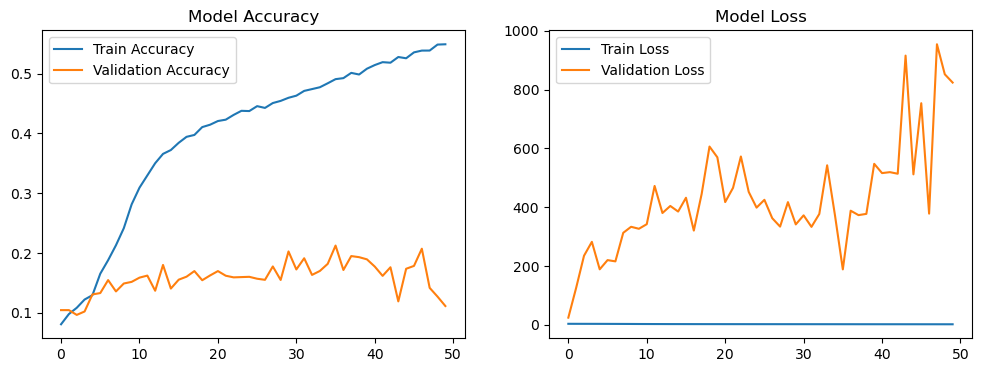

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

Precision — показывает, насколько точно модель предсказывает положительные классы. Если модель классифицирует кадры с Гомером Симпсоном, и она предсказывает 10 кадров как "Гомер", но только 8 из них действительно являются Гомером, то precision будет равен 80%.


Recall — это метрика, которая показывает, насколько хорошо модель находит все истинные положительные примеры. Если в наборе данных есть 15 кадров с Гомером, а модель правильно классифицировала только 8 из них, то recall будет равен 53% (8 истинных положительных из 15 фактических положительных).


F1-score — это гармоническое среднее между precision и recall. Он позволяет объединить обе метрики в одну и дает более полное представление о производительности модели. Использование F1-score полезно в ситуациях с несбалансированными классами, когда важно учитывать как точность, так и полноту.

Support — это просто количество истинных экземпляров для каждого класса в тестовом наборе данных. Показывает, сколько тестовых примеров есть в каждом классе и помогает понять распределение классов в данных.

Лосс (или функция потерь) — это мера, которая показывает, насколько хорошо или плохо модель предсказывает результаты по сравнению с фактическими значениями. Она используется для оценки качества модели во время обучения и оптимизации. Лосс помогает алгоритму понять, насколько далеко его предсказания от истинных значений, и на основании этого корректировать свои параметры. Используется в процессе обучения, тогда как метрики — оценивают его итог.

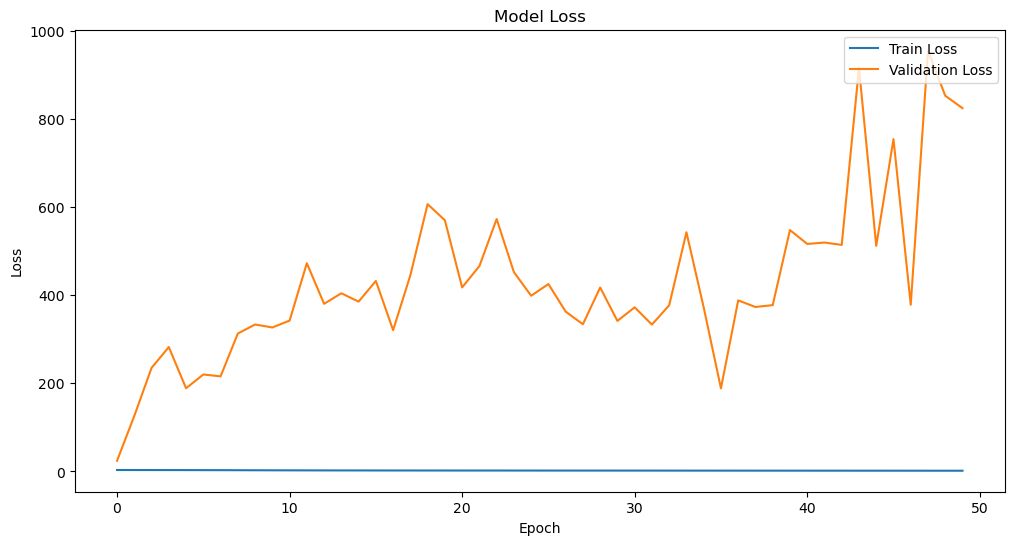

In [71]:
# Построение графика loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()